In [12]:
fname = "234_203"
sigma = 4.5

%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

In [13]:
df = pd.read_csv("./input/clean_"+fname+".csv")
#df.drop(["meter_id"],axis=1,inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72970 entries, 0 to 72969
Data columns (total 3 columns):
meter_id     72970 non-null object
Timestamp    72970 non-null object
Values       72970 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB
None


<IPython.core.display.Javascript object>


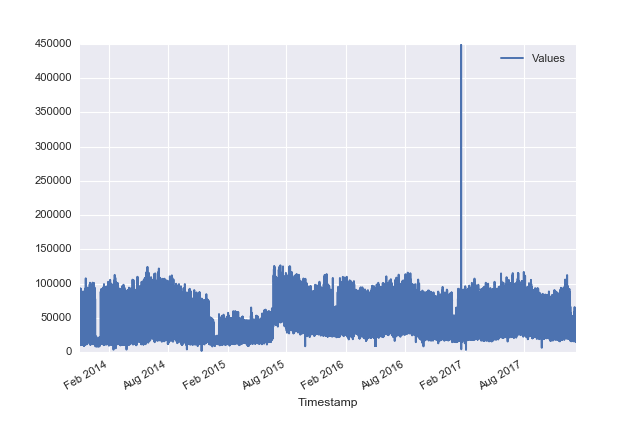

In [14]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.plot(x='Timestamp', y='Values')

In [15]:
df['seconds'] = df['Timestamp'].dt.second
df['minutes'] = df['Timestamp'].dt.minute 
df['hours'] = df['Timestamp'].dt.hour
df['min'] = df['hours'].map(str)+":"+df['minutes'].map(str)
df['years'] = df['Timestamp'].dt.year
df['days'] = df['Timestamp'].dt.day
df['months'] = df['Timestamp'].dt.month
df['DayOfTheWeek'] = df['Timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df['daylight'] = ((df['hours'] >= 8) & (df['hours'] <= 20)).astype(int)
df['mnth'] = df['months'].map(str)+":"+df['years'].map(str)
df['time_epoch'] = (df['Timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [16]:
df.head()

,meter_id,Timestamp,Values,seconds,minutes,hours,min,years,days,months,DayOfTheWeek,WeekDay,daylight,mnth,time_epoch
0,234_203,2013-11-03 19:00:00,11636.0,0,0,19,19:0,2013,3,11,6,0,1,11:2013,13835052
1,234_203,2013-11-03 19:30:00,11106.0,0,30,19,19:30,2013,3,11,6,0,1,11:2013,13835070
2,234_203,2013-11-03 20:00:00,10957.0,0,0,20,20:0,2013,3,11,6,0,1,11:2013,13835088
3,234_203,2013-11-03 20:30:00,11157.0,0,30,20,20:30,2013,3,11,6,0,1,11:2013,13835106
4,234_203,2013-11-03 21:00:00,12196.0,0,0,21,21:0,2013,3,11,6,0,0,11:2013,13835124


In [17]:
cols =  ["years","DayOfTheWeek","min"]
#cols =  ["DayOfTheWeek","min"]
#cols =  ["mnth","DayOfTheWeek","min"]
ds = df[(df["years"]!=2013)&(df["years"]!=2018)]
dm = dict(ds.groupby(by=cols)["Values"].mean())
dv = dict(ds.groupby(by=cols)["Values"].std())
dc = dict(ds.groupby(by=cols)["Values"].count())
df["key"] = list(zip(df[cols[0]], df[cols[1]], df[cols[2]]))

s = []
c = []
for x in dm:
    try:
        t = dm[x]/dv[x]
        s.append(t)
        c.append(dc[x])
    except:
        print(x,dm[x],dv[x],dm[x]/dv[x])
        
np.min(s),np.median(s),np.mean(s),np.max(s),np.median(c)

# (1.5721964587016286,
#  3.5356684823684681,
#  3.7218237724146865,
#  12.115652686070522,
#  104.0) ["years","DayOfTheWeek","hours"]

# (1.5496517021971126,
#  3.5506656797537763,
#  3.75694785168103,
#  12.448457516913999,
#  52.0) ["years","DayOfTheWeek","min"]

(1.5496517021971126,
 3.5506656797537763,
 3.75694785168103,
 12.448457516913999,
 52.0)

In [18]:
df["years"].value_counts()

2016    17515
2014    17488
2015    17475
2017    17417
2013     2739
2018      336
Name: years, dtype: int64

In [19]:
from tqdm import tqdm
a = []
for key, value in zip(df.key, df.Values):
    try:
        a.append(int(abs(dm[key]-value)>sigma*dv[key]))
    except:
        a.append(0)
        #print(key)
df['anomaly21'] = a
print(sum(a),sum(a)/len(df))

159 0.0021789776620528985


<IPython.core.display.Javascript object>


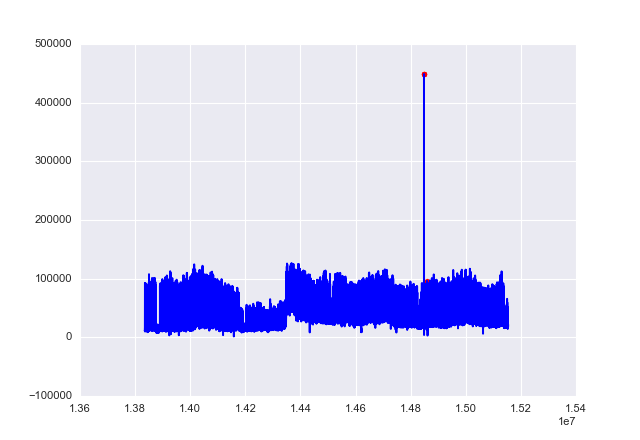

In [20]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'Values']] #anomaly

ax.plot(df['time_epoch'], df['Values'], color='blue')
ax.scatter(a['time_epoch'],a['Values'], color='red')
plt.show()

<IPython.core.display.Javascript object>


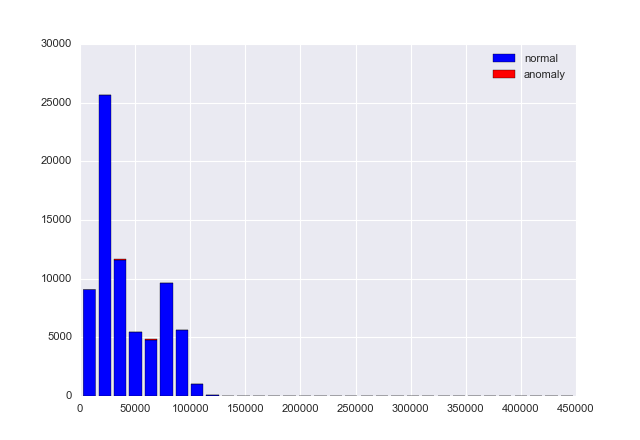

In [21]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'Values']
b = df.loc[df['anomaly21'] == 1, 'Values']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [22]:
df.to_csv("./output/"+fname+".csv", columns=["meter_id","Timestamp","anomaly21", "Values"], index=False)